<a href="https://colab.research.google.com/github/ashish244co/Deep-Hybrid-Learning/blob/master/PytorchGradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as ply
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(torch.cuda.device_count())

1


In [3]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
device = torch.device('cuda:0')

In [0]:
import pandas as pd
from sklearn.datasets import california_housing
from sklearn import datasets

In [0]:
housing_data = california_housing.fetch_california_housing()
Features = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
Target = pd.DataFrame(housing_data.target, columns=['Target'])
df = Features.join(Target)
df = df[df.Target < 5]
X = df.drop('Target',axis=1)
y = df.Target

In [0]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_uniform(m.weight)
        m.bias.data.fill_(1)

In [0]:
class LinearRegression(torch.nn.Module):
  def __init__(self,n_features,output_features):
    super(LinearRegression, self).__init__()
    self.linear = torch.nn.Linear(n_features, output_features)

  def forward(self, x):
        return self.linear(x)

In [0]:
def regression(X,y,lr,epochs,batch_size):
  tlosses=[]
  vlosses=[]
  Xtorch=torch.from_numpy(X.to_numpy()).float().to(device)
  ytorch=torch.from_numpy(y.to_numpy()).float().to(device)
  ytorch=ytorch.view(y.shape[0],1)
  Xtorch=(Xtorch-Xtorch.mean(axis=0))/Xtorch.std(axis=0)
  X_train, X_val, Y_train, Y_val = train_test_split(Xtorch, ytorch,test_size=0.3)
  n_dims=X.shape[1]
  output_size=1
  model=LinearRegression(n_dims,output_size).to(device)
  model.apply(init_weights)
  loss=torch.nn.MSELoss().to(device)
  opt=torch.optim.Adam(model.parameters(),lr=lr)
  for epoch in tqdm(range(epochs)):
    for i in range(0,len(X_train),batch_size):
      
      ypred=model(X_train[i:i+batch_size])
      l=loss(ypred,Y_train[i:i+batch_size])
      l.backward()
      opt.step()
      opt.zero_grad()

    with torch.no_grad():
      vlosses.append(loss(model(X_val),Y_val).item())
      tlosses.append(l.item())
      if((epoch+1)%5==0):
        print("MSE is:",l.item(),', Epoch Number:',epoch)

  with torch.no_grad():
    print("R^2 loss:",r2_score(Y_val.cpu(),model(X_val).cpu()))
    
  return model,tlosses,vlosses

In [10]:
m,l,v=regression(X,y,0.001,20,16)

MSE is: 0.2990338206291199 , Epoch Number: 4
MSE is: 0.2974467873573303 , Epoch Number: 9
MSE is: 0.296707421541214 , Epoch Number: 14
MSE is: 0.29657942056655884 , Epoch Number: 19

R^2 loss: 0.5661172063096753


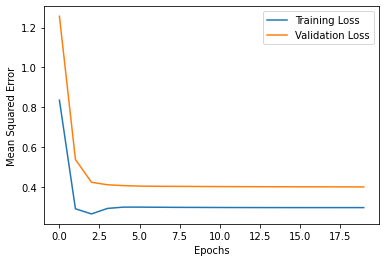

In [11]:
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.plot(l,label='Training Loss')
plt.plot(v,label='Validation Loss')
plt.legend()

In [0]:
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target
n_features = X.shape[1]

In [0]:
Xt = pd.DataFrame(X)
yt = pd.DataFrame(y)

In [0]:
class LinearClassification(torch.nn.Module):
  def __init__(self,n_features,output_features):
    super(LinearClassification, self).__init__()
    self.linear = torch.nn.Linear(n_features, output_features)

  def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [0]:
def classification(X,y,lr,epochs,batch_size):
  tlosses=[]
  vlosses=[]
  Xtorch=torch.from_numpy(X.to_numpy()).float().to(device)
  ytorch=torch.from_numpy(y.to_numpy()).float().to(device)
  ytorch=ytorch.view(y.shape[0],1)
  X=(Xtorch-Xtorch.mean(axis=0))/Xtorch.std(axis=0)
  X_train, X_val, Y_train, Y_val = train_test_split(Xtorch, ytorch,test_size=0.3)
  n_dims=X.shape[1]
  output_size=1
  model=LinearClassification(n_dims,output_size).to(device)
  model.apply(init_weights)
  loss=torch.nn.BCELoss().to(device)
  opt=torch.optim.Adam(model.parameters(),lr=lr)
  for epoch in tqdm(range(epochs)):
    for i in range(0,len(X_train),batch_size):
      ypred=model(X_train[i:i+batch_size])
      l=loss(ypred,Y_train[i:i+batch_size])
      l.backward()
      opt.step()
      opt.zero_grad()

    with torch.no_grad():
      vlosses.append(loss(model(X_val),Y_val).item())
      tlosses.append(l.item())
      if((epoch+1)%5==0):
        print("Binary Cross Entropy loss is:",l.item(),', Epoch Number:',epoch)
  
  with torch.no_grad():
    ypred=(model(X_val)>0.5).cpu().detach().numpy()
    print('Accuracy is:',classification_report(Y_val.cpu().detach().numpy(),ypred))

  return model,tlosses,vlosses

In [16]:
m,l,v=classification(Xt,yt,0.01,20,16)

Binary Cross Entropy loss is: 0.000683075690176338 , Epoch Number: 4
Binary Cross Entropy loss is: 0.10951847583055496 , Epoch Number: 9
Binary Cross Entropy loss is: 0.20492687821388245 , Epoch Number: 14
Binary Cross Entropy loss is: 0.20765160024166107 , Epoch Number: 19

Accuracy is:               precision    recall  f1-score   support

         0.0       0.83      0.96      0.89        70
         1.0       0.97      0.86      0.91       101

    accuracy                           0.90       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.90      0.90       171



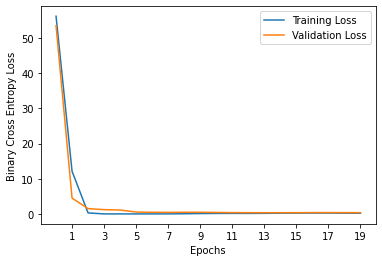

In [17]:
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.xticks(range(1,20,2))
plt.plot(l,label='Training Loss')
plt.plot(v,label='Validation Loss')
plt.legend()